This tutorial shows how to load and preprocess an image dataset in three ways:

- First, you will use high-level Keras preprocessing utilities (such as `tf.keras.utils.image_dataset_from_directory`) and layers (such as `tf.keras.layers.Rescaling`) to read a directory of images on disk.
- Next, you will write your own input pipeline from scratch [using tf.data](../../guide/data.ipynb).
- Finally, you will download a dataset from the large [catalog](https://www.tensorflow.org/datasets/catalog/overview) available in [TensorFlow Datasets](https://www.tensorflow.org/datasets).

## Setup

In [5]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [31]:
print(tf.__version__)

2.7.0
2.7.0


### Download the flowers dataset

This tutorial uses a dataset of several thousand photos of flowers. The flowers dataset contains five sub-directories, one per class:

```
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

Note: all images are licensed CC-BY, creators are listed in the LICENSE.txt file.

In [7]:
import pathlib


dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 23s 0us/step


After downloading (218MB), you should now have a copy of the flower photos available. There are 3,670 total images:

In [8]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Each directory contains images of that type of flower. Here are some roses:

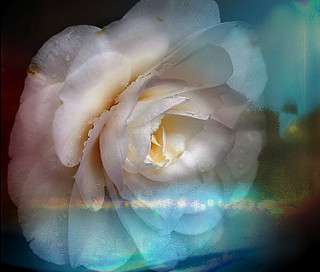

In [9]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

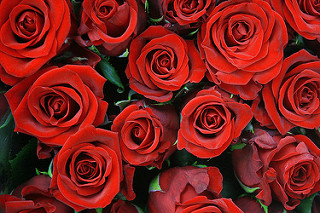

In [10]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

## Load data using a Keras utility

In [11]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. You will use 80% of the images for training and 20% for validation.

In [18]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [19]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [20]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Visualize the data

Here are the first nine images from the training dataset.

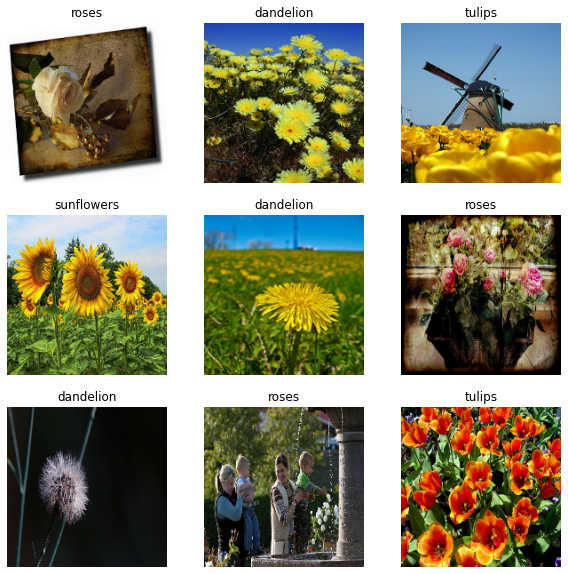

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [23]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on either of these tensors to convert them to a `numpy.ndarray`.

### Standardize the data


The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [24]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


Or, you can include the layer inside your model definition to simplify deployment. You will use the second approach here.

Note: If you would like to scale pixel values to `[-1,1]` you can instead write `tf.keras.layers.Rescaling(1./127.5, offset=-1)`

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

### Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [25]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Train a model

For completeness, you will show how to train a simple model using the datasets you have just prepared.

The [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned in any way—the goal is to show you the mechanics using the datasets you just created. To learn more about image classification, visit the [Image classification](../images/classification.ipynb) tutorial.

In [26]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

Choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [27]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

Note: You will only train for a few epochs so this tutorial runs quickly. 

In [19]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3


 1/92 [..............................] - ETA: 3:13 - loss: 1.6053 - accuracy: 0.3125

 5/92 [>.............................] - ETA: 1s - loss: 1.7504 - accuracy: 0.2812  

 9/92 [=>............................] - ETA: 1s - loss: 1.6987 - accuracy: 0.2500

13/92 [===>..........................] - ETA: 1s - loss: 1.6516 - accuracy: 0.2668

17/92 [====>.........................] - ETA: 1s - loss: 1.6168 - accuracy: 0.2684

21/92 [=====>........................] - ETA: 0s - loss: 1.5828 - accuracy: 0.2902

25/92 [=======>......................] - ETA: 0s - loss: 1.5493 - accuracy: 0.3125

29/92 [========>.....................] - ETA: 0s - loss: 1.5121 - accuracy: 0.3330

33/92 [=========>....................] - ETA: 0s - loss: 1.4764 - accuracy: 0.3485

37/92 [===========>..................] - ETA: 0s - loss: 1.4418 - accuracy: 0.3522

41/92 [============>.................] - ETA: 0s - loss: 1.4141 - accuracy: 0.3674

45/92 [=============>................] - ETA: 0s - loss: 1.3933 - accuracy: 0.3764

49/92 [==============>...............] - ETA: 0s - loss: 1.3878 - accuracy: 0.3807

53/92 [================>.............] - ETA: 0s - loss: 1.3783 - accuracy: 0.3844

58/92 [=================>............] - ETA: 0s - loss: 1.3715 - accuracy: 0.3842

62/92 [===================>..........] - ETA: 0s - loss: 1.3566 - accuracy: 0.3926

66/92 [====================>.........] - ETA: 0s - loss: 1.3459 - accuracy: 0.3958

70/92 [=====================>........] - ETA: 0s - loss: 1.3348 - accuracy: 0.4027

74/92 [=======================>......] - ETA: 0s - loss: 1.3155 - accuracy: 0.4113

78/92 [========================>.....] - ETA: 0s - loss: 1.3150 - accuracy: 0.4151

83/92 [==========================>...] - ETA: 0s - loss: 1.3122 - accuracy: 0.4213

88/92 [===========================>..] - ETA: 0s - loss: 1.3066 - accuracy: 0.4276

92/92 [==============================] - ETA: 0s - loss: 1.3091 - accuracy: 0.4281

92/92 [==============================] - 4s 21ms/step - loss: 1.3091 - accuracy: 0.4281 - val_loss: 1.0982 - val_accuracy: 0.5599


Epoch 2/3


 1/92 [..............................] - ETA: 1s - loss: 1.1515 - accuracy: 0.5938

 6/92 [>.............................] - ETA: 0s - loss: 1.0559 - accuracy: 0.5781

11/92 [==>...........................] - ETA: 0s - loss: 1.0488 - accuracy: 0.5511

16/92 [====>.........................] - ETA: 0s - loss: 1.0123 - accuracy: 0.5742

21/92 [=====>........................] - ETA: 0s - loss: 1.0162 - accuracy: 0.5714

26/92 [=======>......................] - ETA: 0s - loss: 1.0274 - accuracy: 0.5733

31/92 [=========>....................] - ETA: 0s - loss: 1.0301 - accuracy: 0.5786

36/92 [==========>...................] - ETA: 0s - loss: 1.0115 - accuracy: 0.5833

41/92 [============>.................] - ETA: 0s - loss: 1.0064 - accuracy: 0.5877

46/92 [==============>...............] - ETA: 0s - loss: 1.0124 - accuracy: 0.5883

51/92 [===============>..............] - ETA: 0s - loss: 1.0152 - accuracy: 0.5852

56/92 [=================>............] - ETA: 0s - loss: 1.0236 - accuracy: 0.5798

61/92 [==================>...........] - ETA: 0s - loss: 1.0232 - accuracy: 0.5825

66/92 [====================>.........] - ETA: 0s - loss: 1.0161 - accuracy: 0.5876

71/92 [======================>.......] - ETA: 0s - loss: 1.0105 - accuracy: 0.5902

76/92 [=======================>......] - ETA: 0s - loss: 1.0104 - accuracy: 0.5925

81/92 [=========================>....] - ETA: 0s - loss: 1.0104 - accuracy: 0.5918

86/92 [===========================>..] - ETA: 0s - loss: 1.0077 - accuracy: 0.5941

91/92 [============================>.] - ETA: 0s - loss: 1.0191 - accuracy: 0.5883

92/92 [==============================] - 1s 12ms/step - loss: 1.0196 - accuracy: 0.5879 - val_loss: 0.9572 - val_accuracy: 0.6213


Epoch 3/3


 1/92 [..............................] - ETA: 0s - loss: 0.9807 - accuracy: 0.6562

 6/92 [>.............................] - ETA: 0s - loss: 0.8763 - accuracy: 0.6927

11/92 [==>...........................] - ETA: 0s - loss: 0.8874 - accuracy: 0.6705

16/92 [====>.........................] - ETA: 0s - loss: 0.8672 - accuracy: 0.6738

21/92 [=====>........................] - ETA: 0s - loss: 0.8550 - accuracy: 0.6771

26/92 [=======>......................] - ETA: 0s - loss: 0.8652 - accuracy: 0.6827

31/92 [=========>....................] - ETA: 0s - loss: 0.8746 - accuracy: 0.6764

36/92 [==========>...................] - ETA: 0s - loss: 0.8582 - accuracy: 0.6814

41/92 [============>.................] - ETA: 0s - loss: 0.8554 - accuracy: 0.6784

46/92 [==============>...............] - ETA: 0s - loss: 0.8551 - accuracy: 0.6739

51/92 [===============>..............] - ETA: 0s - loss: 0.8601 - accuracy: 0.6703

56/92 [=================>............] - ETA: 0s - loss: 0.8609 - accuracy: 0.6685

61/92 [==================>...........] - ETA: 0s - loss: 0.8575 - accuracy: 0.6721

66/92 [====================>.........] - ETA: 0s - loss: 0.8468 - accuracy: 0.6766

71/92 [======================>.......] - ETA: 0s - loss: 0.8466 - accuracy: 0.6761

76/92 [=======================>......] - ETA: 0s - loss: 0.8442 - accuracy: 0.6776

81/92 [=========================>....] - ETA: 0s - loss: 0.8449 - accuracy: 0.6775

86/92 [===========================>..] - ETA: 0s - loss: 0.8398 - accuracy: 0.6806

91/92 [============================>.] - ETA: 0s - loss: 0.8456 - accuracy: 0.6775

92/92 [==============================] - 1s 12ms/step - loss: 0.8455 - accuracy: 0.6775 - val_loss: 0.8839 - val_accuracy: 0.6512


Note: You can also write a custom training loop instead of using `Model.fit`. To learn more, visit the [Writing a training loop from scratch](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch) tutorial.

You may notice the validation accuracy is low compared to the training accuracy, indicating your model is overfitting. You can learn more about overfitting and how to reduce it in this [tutorial](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

## Using tf.data for finer control

The above Keras preprocessing utility—`tf.keras.utils.image_dataset_from_directory`—is a convenient way to create a `tf.data.Dataset` from a directory of images.

For finer grain control, you can write your own input pipeline using `tf.data`. This section shows how to do just that, beginning with the file paths from the TGZ file you downloaded earlier.

In [20]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [21]:
for f in list_ds.take(5):
  print(f.numpy())

b'/home/kbuilder/.keras/datasets/flower_photos/roses/14267691818_301aceda07.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/daisy/2641151167_3bf1349606_m.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/sunflowers/6495554833_86eb8faa8e_n.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/tulips/4578030672_e6aefd45af.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/dandelion/144686365_d7e96941ee_n.jpg'


The tree structure of the files can be used to compile a `class_names` list.

In [22]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


Split the dataset into training and validation sets:

In [23]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

You can print the length of each dataset as follows:

In [24]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


Write a short function that converts a file path to an `(img, label)` pair:

In [25]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [26]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [27]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Use `Dataset.map` to create a dataset of `image, label` pairs:

In [28]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [29]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  1


### Configure dataset for performance

To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be added using the `tf.data` API. For more details, visit the [Input Pipeline Performance](../../guide/performance/datasets.ipynb) guide.

In [30]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

### Visualize the data

You can visualize this dataset similarly to the one you created previously:

2022-01-26 06:29:45.209901: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


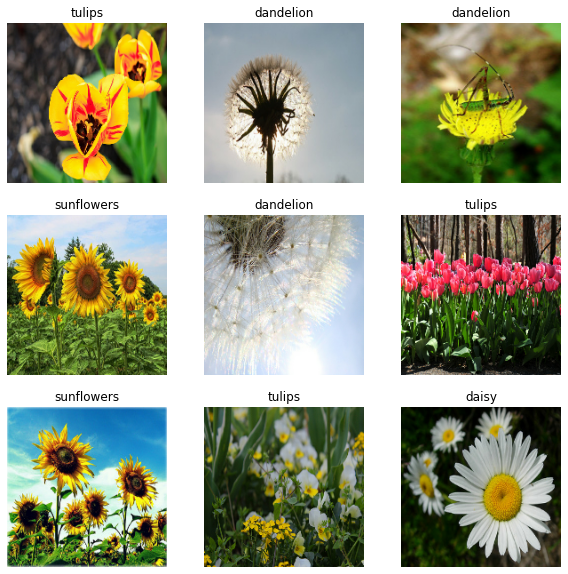

In [31]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

### Continue training the model

You have now manually built a similar `tf.data.Dataset` to the one created by `tf.keras.utils.image_dataset_from_directory` above. You can continue training the model with it. As before, you will train for just a few epochs to keep the running time short.

In [32]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3


 1/92 [..............................] - ETA: 1:10 - loss: 0.5563 - accuracy: 0.8438

 4/92 [>.............................] - ETA: 1s - loss: 0.6199 - accuracy: 0.7812  

 8/92 [=>............................] - ETA: 1s - loss: 0.6739 - accuracy: 0.7578

12/92 [==>...........................] - ETA: 1s - loss: 0.6808 - accuracy: 0.7552

16/92 [====>.........................] - ETA: 1s - loss: 0.6830 - accuracy: 0.7422

20/92 [=====>........................] - ETA: 1s - loss: 0.6987 - accuracy: 0.7297

24/92 [======>.......................] - ETA: 1s - loss: 0.7278 - accuracy: 0.7174

28/92 [========>.....................] - ETA: 1s - loss: 0.7219 - accuracy: 0.7243

32/92 [=========>....................] - ETA: 0s - loss: 0.7362 - accuracy: 0.7217

36/92 [==========>...................] - ETA: 0s - loss: 0.7399 - accuracy: 0.7179

40/92 [============>.................] - ETA: 0s - loss: 0.7445 - accuracy: 0.7148

44/92 [=============>................] - ETA: 0s - loss: 0.7463 - accuracy: 0.7173

48/92 [==============>...............] - ETA: 0s - loss: 0.7503 - accuracy: 0.7194

51/92 [===============>..............] - ETA: 0s - loss: 0.7431 - accuracy: 0.7212

54/92 [================>.............] - ETA: 0s - loss: 0.7490 - accuracy: 0.7182

57/92 [=================>............] - ETA: 0s - loss: 0.7552 - accuracy: 0.7138

60/92 [==================>...........] - ETA: 0s - loss: 0.7513 - accuracy: 0.7141

65/92 [====================>.........] - ETA: 0s - loss: 0.7455 - accuracy: 0.7183

70/92 [=====================>........] - ETA: 0s - loss: 0.7497 - accuracy: 0.7134

75/92 [=======================>......] - ETA: 0s - loss: 0.7390 - accuracy: 0.7192

80/92 [=========================>....] - ETA: 0s - loss: 0.7310 - accuracy: 0.7230

85/92 [==========================>...] - ETA: 0s - loss: 0.7292 - accuracy: 0.7221

90/92 [============================>.] - ETA: 0s - loss: 0.7282 - accuracy: 0.7243

92/92 [==============================] - 3s 21ms/step - loss: 0.7305 - accuracy: 0.7245 - val_loss: 0.7311 - val_accuracy: 0.7139


Epoch 2/3


 1/92 [..............................] - ETA: 1s - loss: 0.6420 - accuracy: 0.8438

 6/92 [>.............................] - ETA: 0s - loss: 0.4706 - accuracy: 0.8438

11/92 [==>...........................] - ETA: 0s - loss: 0.5050 - accuracy: 0.8239

16/92 [====>.........................] - ETA: 0s - loss: 0.5026 - accuracy: 0.8184

21/92 [=====>........................] - ETA: 0s - loss: 0.4923 - accuracy: 0.8199

26/92 [=======>......................] - ETA: 0s - loss: 0.5176 - accuracy: 0.8089

31/92 [=========>....................] - ETA: 0s - loss: 0.5111 - accuracy: 0.8095

36/92 [==========>...................] - ETA: 0s - loss: 0.5281 - accuracy: 0.7977

41/92 [============>.................] - ETA: 0s - loss: 0.5287 - accuracy: 0.7988

46/92 [==============>...............] - ETA: 0s - loss: 0.5341 - accuracy: 0.7982

51/92 [===============>..............] - ETA: 0s - loss: 0.5336 - accuracy: 0.7990

56/92 [=================>............] - ETA: 0s - loss: 0.5356 - accuracy: 0.7980

61/92 [==================>...........] - ETA: 0s - loss: 0.5378 - accuracy: 0.7987

66/92 [====================>.........] - ETA: 0s - loss: 0.5332 - accuracy: 0.7988

71/92 [======================>.......] - ETA: 0s - loss: 0.5288 - accuracy: 0.8015

76/92 [=======================>......] - ETA: 0s - loss: 0.5322 - accuracy: 0.8018

81/92 [=========================>....] - ETA: 0s - loss: 0.5314 - accuracy: 0.8025

86/92 [===========================>..] - ETA: 0s - loss: 0.5285 - accuracy: 0.8041

91/92 [============================>.] - ETA: 0s - loss: 0.5295 - accuracy: 0.8067

92/92 [==============================] - 1s 13ms/step - loss: 0.5279 - accuracy: 0.8069 - val_loss: 0.7021 - val_accuracy: 0.7316


Epoch 3/3


 1/92 [..............................] - ETA: 1s - loss: 0.3370 - accuracy: 0.8438

 6/92 [>.............................] - ETA: 0s - loss: 0.2899 - accuracy: 0.8958

11/92 [==>...........................] - ETA: 0s - loss: 0.3127 - accuracy: 0.8977

16/92 [====>.........................] - ETA: 0s - loss: 0.3100 - accuracy: 0.9004

21/92 [=====>........................] - ETA: 0s - loss: 0.3250 - accuracy: 0.8884

26/92 [=======>......................] - ETA: 0s - loss: 0.3295 - accuracy: 0.8858

31/92 [=========>....................] - ETA: 0s - loss: 0.3285 - accuracy: 0.8881

36/92 [==========>...................] - ETA: 0s - loss: 0.3288 - accuracy: 0.8898

41/92 [============>.................] - ETA: 0s - loss: 0.3389 - accuracy: 0.8857

46/92 [==============>...............] - ETA: 0s - loss: 0.3531 - accuracy: 0.8784

51/92 [===============>..............] - ETA: 0s - loss: 0.3531 - accuracy: 0.8768

56/92 [=================>............] - ETA: 0s - loss: 0.3603 - accuracy: 0.8756

61/92 [==================>...........] - ETA: 0s - loss: 0.3647 - accuracy: 0.8704

66/92 [====================>.........] - ETA: 0s - loss: 0.3676 - accuracy: 0.8688

71/92 [======================>.......] - ETA: 0s - loss: 0.3704 - accuracy: 0.8653

76/92 [=======================>......] - ETA: 0s - loss: 0.3708 - accuracy: 0.8651

81/92 [=========================>....] - ETA: 0s - loss: 0.3728 - accuracy: 0.8650

86/92 [===========================>..] - ETA: 0s - loss: 0.3739 - accuracy: 0.8637

91/92 [============================>.] - ETA: 0s - loss: 0.3728 - accuracy: 0.8644

92/92 [==============================] - 1s 13ms/step - loss: 0.3739 - accuracy: 0.8644 - val_loss: 0.8266 - val_accuracy: 0.6948


## Using TensorFlow Datasets

So far, this tutorial has focused on loading data off disk. You can also find a dataset to use by exploring the large [catalog](https://www.tensorflow.org/datasets/catalog/overview) of easy-to-download datasets at [TensorFlow Datasets](https://www.tensorflow.org/datasets).

As you have previously loaded the Flowers dataset off disk, let's now import it with TensorFlow Datasets.

Download the Flowers [dataset](https://www.tensorflow.org/datasets/catalog/tf_flowers) using TensorFlow Datasets:

In [33]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

The flowers dataset has five classes:

In [34]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


 Retrieve an image from the dataset:

2022-01-26 06:29:54.281352: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


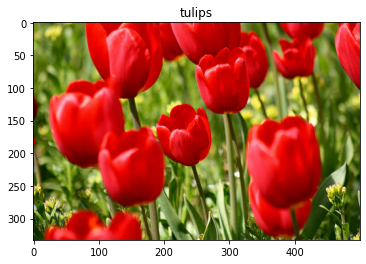

In [35]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

As before, remember to batch, shuffle, and configure the training, validation, and test sets for performance:

In [36]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

You can find a complete example of working with the Flowers dataset and TensorFlow Datasets by visiting the [Data augmentation](../images/data_augmentation.ipynb) tutorial.

## Next steps

This tutorial showed two ways of loading images off disk. First, you learned how to load and preprocess an image dataset using Keras preprocessing layers and utilities. Next, you learned how to write an input pipeline from scratch using `tf.data`. Finally, you learned how to download a dataset from TensorFlow Datasets.

For your next steps:

- You can learn [how to add data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation).
- To learn more about `tf.data`, you can visit the [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data) guide.